In [27]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,concatenate, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten,Conv2D, Convolution2D, Reshape
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D,Conv2DTranspose
from tensorflow.keras.models import Model

In [28]:
import cv2 
import glob 
import os 
import numpy as np

In [6]:
NO_OF_TRAINING_IMAGES = len(os.listdir('/data/train'))
NO_OF_VAL_IMAGES = len(os.listdir('/data/test'))


In [7]:
NO_OF_TRAINING_IMAGES

2

In [11]:
train_in_images_path = '/data/train/'
train_in_labels_path  = '/data/mask/'
test_in_images_path = '/data/test/'
test_in_labels_path = '/data/mask_test/'

In [12]:
def load_img_data_tensor(path,h,w,c):
    N = len(os.listdir(path))
    data_out= np.zeros((N,h,w,c),'float')
    
    for i in range(0,N):
        
        img_name = os.listdir(path)[i]
        
        img = cv2.imread(path + img_name)
        img = cv2.resize(img,(256,256))
        if(c >1):
            
            img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            data_out[i] = img_rgb
        else:
            
            img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            
            data_out[i] = np.expand_dims(img_gray, axis=2)
        
        #print (i)
    return data_out
            
            
        
    
    
    

In [13]:

img_height = 256 
img_width = 256

train_image_orig = load_img_data_tensor(train_in_images_path,img_height,img_width,3)
train_mask_orig = load_img_data_tensor(train_in_labels_path,img_height,img_width,1)
val_image_orig = load_img_data_tensor(test_in_images_path,img_height,img_width,3)
val_mask_orig = load_img_data_tensor(test_in_labels_path,img_height,img_width,1)

In [14]:
X_train = train_image_orig/255.
X_test = val_image_orig/255.
Y_train = train_mask_orig/255.
Y_test = val_mask_orig/255.
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 2
number of test examples = 2
X_train shape: (2, 256, 256, 3)
Y_train shape: (2, 256, 256, 1)
X_test shape: (2, 256, 256, 3)
Y_test shape: (2, 256, 256, 1)


In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [16]:
def Unet_model(input_shape,n_filters=16,dropout=.1,batchnorm=True):
    
    X_input = Input(input_shape)
    
    c1 = conv2d_block(X_input,n_filters*1,kernel_size=3,batchnorm=batchnorm)     
    p1 = MaxPooling2D((2,2))(c1)           # (h/2,w/2,16)
    p1 = Dropout(dropout)(p1) 
    
    c2 = conv2d_block(p1,n_filters*2,kernel_size=3,batchnorm=batchnorm)
    p2 = MaxPooling2D((2,2))(c2)  # (h/4,w/4,32)
    p2 = Dropout(dropout)(p2) 
    
    c3 = conv2d_block(p2,n_filters*4,kernel_size=3,batchnorm=batchnorm)
    p3 = MaxPooling2D((2,2))(c3)  # (h/8,w/8,64)
    p3 = Dropout(dropout)(p3) 
    
    c4 = conv2d_block(p3,n_filters*8,kernel_size=3,batchnorm=batchnorm)
    p4 = MaxPooling2D((2,2))(c4)  # (h/16,w/16,128)
    p4 = Dropout(dropout)(p4) 
    
    c5 = conv2d_block(p4,n_filters*16,kernel_size=3,batchnorm=batchnorm)      # (h/16,w/16,256)

    
    print("encoder done")
    
    
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)  # (h/8,w/8,128)
    u6 = concatenate([u6, c4])   # (h/8,w/8,128)
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)     # (h/8,w/8,128)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)  # (h/4,w/4,64)
    u7 = concatenate([u7, c3])   # (h/8,w/8,128)
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)     # (h/4,w/4,64)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)  # (h/2,w/2,32)
    u8 = concatenate([u8, c2])   # (h/2,w/2,32)
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters *2 , kernel_size = 3, batchnorm = batchnorm)     # (h/2,w/2,32)
    
    u9 = Conv2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = 'same')(c8)  # (h,w,16)
    u9 = concatenate([u9, c1])   # (h,w,16)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters, kernel_size = 3, batchnorm = batchnorm)     # (h,w,16)    
    
    
    print("decoder done")
    X_outputs = Conv2D(1,(1,1),activation='sigmoid')(c9)
    
    model = Model(inputs=X_input,outputs=X_outputs,name='Unet_model')
    
    return model
    
    
    
    

In [17]:
unetmodel = Unet_model((256,256,3))

encoder done
decoder done


In [18]:
unetmodel.compile(loss='binary_crossentropy', optimizer="Adam", metrics = ["accuracy"])

In [19]:
unetmodel.fit(x = X_train, y = Y_train, epochs = 5, batch_size = 2)

Epoch 1/5
2/2 [==============================] - 2s 1s/step - loss: 0.5524 - acc: 0.7156
Epoch 2/5
2/2 [==============================] - 1s 338ms/step - loss: 0.4914 - acc: 0.7715
Epoch 3/5
2/2 [==============================] - 1s 336ms/step - loss: 0.4499 - acc: 0.8100
Epoch 4/5
2/2 [==============================] - 1s 342ms/step - loss: 0.4190 - acc: 0.8369
Epoch 5/5
2/2 [==============================] - 1s 337ms/step - loss: 0.3944 - acc: 0.8511


In [20]:
model_save_path = '/data/unet_model_UBIRIS_1.h5'

unetmodel.save(model_save_path)

In [21]:
X_test[0:1].shape

(1, 256, 256, 3)

In [22]:
preds = unetmodel.predict(X_test[0:1])

In [23]:
preds.shape

(1, 256, 256, 1)

In [24]:
import matplotlib.pyplot as plt

In [25]:
out_image = np.squeeze(preds)


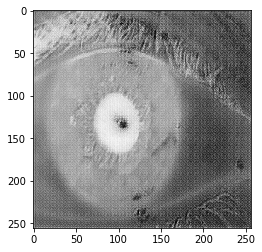

In [26]:
plt.imshow(out_image,cmap='gray')
plt.show()

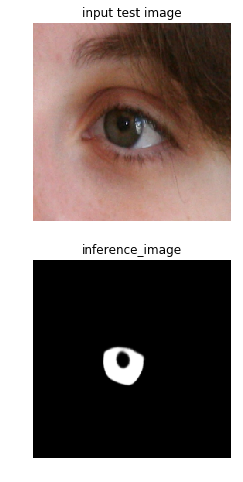

In [22]:
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = 2
fig.add_subplot(rows, columns, 1)
plt.axis("off")
plt.title("input test image")
plt.imshow(X_test[0])
fig.add_subplot(rows, columns, 2)
plt.axis("off")
plt.title("inference_image")
plt.imshow(out_image,cmap='gray')